# Extract contours from RTSTRUCT file
# Method 1: Hacking Dicom-Contour

In [12]:
import pydicom as pd
from dicom_contour import contour
import os
import numpy as np
import cv2
from glob import glob
from shutil import copyfile
import matplotlib.pyplot as plt

## Rename CT image files to their SOPInstanceUID field

In [4]:
# Rename CT slices
filelist = glob('./lung_ct_scan/*dcm')
dicom_files = [pd.read_file(filename) for filename in filelist]

# Make a new folder for saving the renamed dicom files
new_folder = './lung_ct_scan_renamed/'
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

# Loop through dicom files and rename any with the 'CT' modality field
for i, dc in enumerate(dicom_files):
    old_name = filelist[i]
    if dc.Modality == 'CT':
        new_name = new_folder + dc.SOPInstanceUID + '.dcm'
    else:
        new_name = old_name.replace('lung_ct_scan','lung_ct_scan_renamed')
    copyfile(old_name, new_name)
        

## Use dicom-contour module to get contours

In [5]:
root = './lung_ct_scan_renamed'

contour_filename = '1-1.dcm'

contour_file_path = os.path.join(root, contour_filename)

# Load RTSTRUCT dicom file
contour_dc = pd.read_file(contour_file_path)

# Check names of ROI contours
roi_names = contour.get_roi_names(contour_dc)

for name in roi_names:
    print(name)

SpinalCord
Lung_R
Lung_L
Heart
Esophagus


In [6]:
# Get the indices for right and left lung contours
lung_r_idx = roi_names.index('Lung_R')
lung_l_idx = roi_names.index('Lung_L')

scan, lung_r_ctr = contour.get_data(root, lung_r_idx)
_, lung_l_ctr = contour.get_data(root, lung_l_idx)

print('Scan shape:', scan.shape)
print('Right lung shape:', lung_r_ctr.shape)
print('Left lung shape:', lung_l_ctr.shape)

Scan shape: (130, 512, 512)
Right lung shape: (130, 512, 512)
Left lung shape: (130, 512, 512)


In [11]:
# Combine right and left lung contours
lung_ctr = np.bitwise_or(lung_r_ctr, lung_l_ctr)

# Convert arrays into 8-bit unsigned integer format for visualization with OpenCV
scan = cv2.normalize(scan, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
lung_ctr = cv2.normalize(lung_ctr, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Loop through scan and contour array
for img, ctr in zip(scan, lung_ctr):
    
    cv2.imshow('Lung CT', cv2.hconcat([img, ctr]))
    cv2.waitKey(100)
    
cv2.destroyAllWindows()

### Notice how the contours are acutally small dots - this is a problem
### Solution: use image processing to join up the points together

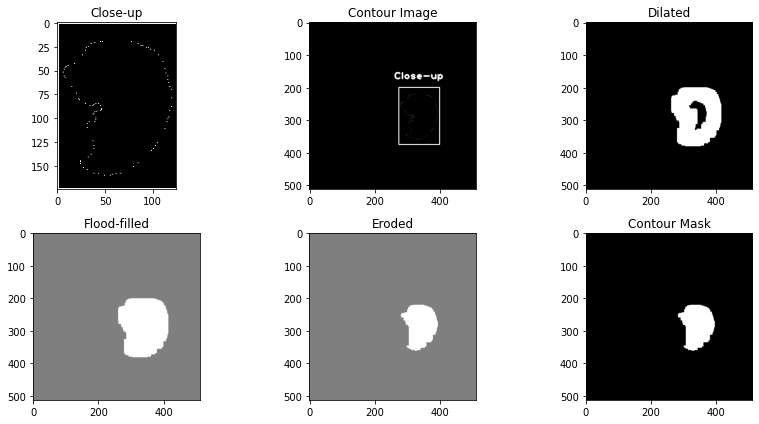

In [73]:
# Try using an example image
ctr_img = lung_l_ctr[77]

# Convert to unsigned 8-bit integer
ctr_img = cv2.normalize(ctr_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
ctr_img_show = ctr_img.copy()
cv2.rectangle(ctr_img_show, (275,200), (400,375), 255, 2)
cv2.putText(ctr_img_show, 'Close-up', (260, 175), cv2.FONT_HERSHEY_PLAIN, 2, 255, 3)

# Dilation
ksize = 9
kernel = np.ones((ksize,ksize))
ctr_img_dil = cv2.dilate(ctr_img, kernel, None, None, 5)

# Flood-fill
ctr_img_ff = ctr_img_dil.copy()
ctr_img_ff = cv2.floodFill(ctr_img_ff, None, (0,0), 127)[1]
ctr_img_ff[ctr_img_ff==0] = 255

# Erosion
ctr_img_ero = cv2.erode(ctr_img_ff, kernel, None, None, 5)

# Mask image
ctr_img_msk = (ctr_img_ero - 127) / 127

plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.imshow(ctr_img_show[200:375, 275:400], 'gray', vmin=0, vmax=255)
plt.title('Close-up')
plt.subplot(2, 3, 2)
plt.imshow(ctr_img_show, 'gray', vmin=0, vmax=255)
plt.title('Contour Image')
plt.subplot(2, 3, 3)
plt.imshow(ctr_img_dil, 'gray', vmin=0, vmax=255)
plt.title('Dilated')
plt.subplot(2, 3, 4)
plt.imshow(ctr_img_ff, 'gray', vmin=0, vmax=255)
plt.title('Flood-filled')
plt.subplot(2, 3, 5)
plt.imshow(ctr_img_ero, 'gray', vmin=0, vmax=255)
plt.title('Eroded')
plt.subplot(2, 3, 6)
plt.imshow(ctr_img_msk, 'gray', vmin=0, vmax=1)
plt.title('Contour Mask')
plt.tight_layout()
plt.show()

### Combine image processing algorithm into a function

In [79]:
def join_points(lung_seg_im, ksize, num_morph):
    
    kernel = np.ones((ksize,ksize))
    
    lung_seg_im = cv2.dilate(lung_seg_im, kernel, None, None, 
                             num_morph)
    
    lung_seg_im = cv2.floodFill(lung_seg_im, None, (0,0), 127)[1]
    
    lung_seg_im[lung_seg_im==0] = 255
    
    lung_seg_im = cv2.erode(lung_seg_im, kernel, None, None, 
                            num_morph)

    lung_seg_im = (lung_seg_im - 127) / 127
    
    return lung_seg_im.astype('uint8')

## Use function to make contour masks then find outer contour

In [88]:
scan = cv2.normalize(scan, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

lung_r_ctr = cv2.normalize(lung_r_ctr, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
lung_l_ctr = cv2.normalize(lung_l_ctr, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

for img, ctr_r, ctr_l in zip(scan, lung_r_ctr, lung_l_ctr):
    
    ctr_r = join_points(ctr_r, 5, 8)
    ctr_l = join_points(ctr_l, 5, 9)
    
    ctr = np.bitwise_or(ctr_r, ctr_l)
    
    ctrs, _ = cv2.findContours(ctr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    img = cv2.merge([img, img, img]) # Convert grayscale into three channel image
    
    for ctr in ctrs:
        
        if ctr[0][0][0] < 256: # If first contour point is in the left half of the array
            
            cv2.drawContours(img, [ctr], 0, (0, 255, 0), 1)
            
        else:
            
            cv2.drawContours(img, [ctr], 0, (0, 0, 255), 1)

    cv2.imshow('Lung CT', img)
    cv2.waitKey(100)  

cv2.destroyAllWindows() 

# Method 2: Extracting raw contour points from RTSTRUCT dicom file

In [86]:
# Get dicom files for whole CT scan, convert into 3D array of 'uint8' data type

filelist = glob('./lung_ct_scan/*.dcm')
dicom_files = [pd.read_file(file) for file in filelist]
dicom_files = [dc for dc in dicom_files if dc.Modality == 'CT']
dicom_files.sort(key = lambda x: x.ImagePositionPatient[2])
scan = np.array([dc.pixel_array for dc in dicom_files])
scan = cv2.normalize(scan, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

In [83]:
# Get data for transforming patient position coordinates into 3D array coordinates 

z_locs = np.array([dc.SliceLocation for dc in dicom_files])
z_min, z_max = z_locs[0], z_locs[-1]

z_n, x_n, y_n = scan.shape

dc = dicom_files[0]

x_min, y_min, _ = np.array(dc.ImagePositionPatient, np.float32)

x_spacing, y_spacing = np.array(dc.PixelSpacing, np.float32)

x_max = x_min + (x_n * x_spacing)
y_max = y_min + (y_n * y_spacing)

z_spacing = float(dc.SliceThickness)

In [90]:
# Read RTSTRUCT dicomfile
rt = pd.read_file('./lung_ct_scan/1-1.dcm')

for i in range(len(rt.RTROIObservationsSequence)):

    print(rt.RTROIObservationsSequence[i].ObservationNumber, rt.RTROIObservationsSequence[i].ROIObservationLabel)

    print(len(rt.ROIContourSequence[i].ContourSequence), 'frames')
    
    label = rt.RTROIObservationsSequence[i].ROIObservationLabel

    if label == 'Lung_L' or label == 'Lung_R':

        for contour in rt.ROIContourSequence[i].ContourSequence:
       
            num_points = contour.NumberOfContourPoints
            point_data = np.array(contour.ContourData).reshape((num_points, 3))
            
            # Normalize patient coordinates and convert to 3D array coordinates
            point_data[:,0] = ((point_data[:,0] - x_min)/(x_max - x_min)) * (x_n - 1)
            point_data[:,1] = ((point_data[:,1] - y_min)/(y_max - y_min)) * (y_n - 1)
            point_data[:,2] = ((point_data[:,2] - z_min)/(z_max - z_min)) * (z_n - 1)

            # Change to integers for indexing locations in 3D array
            point_data = point_data.astype('int')

            frame = point_data[0,2]
            points = point_data[:,:2]

            # Use cv2 to draw/fill contours
            points = points.reshape((1,-1,2))
            scan[frame] = cv2.drawContours(scan[frame], [points], -1, 255, 2)

# Visualize CT images with contours
for i in range(len(scan)):
    cv2.imshow('window', scan[i])
    cv2.waitKey(50)
cv2.destroyAllWindows()

1 SpinalCord
104 frames
2 Lung_R
93 frames
3 Lung_L
82 frames
4 Heart
29 frames
5 Esophagus
74 frames
